In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pysph.base.utils import get_particle_array
from pysph.tools.interpolator import (
    Interpolator, get_bounding_box
)
from pysph.base import nnps
from cyarray.api import UIntArray

In [104]:
def make_test_data(dx=0.2, L=1, hdx=1.0, dim=2):
    _x = np.arange(dx / 2, L, dx)
    if dim == 1:
        x = _x.copy()
        y = np.zeros_like(x)
        z = np.zeros_like(x)
    elif dim == 2:
        x, y = np.meshgrid(_x, _x)
        z = np.zeros_like(x)
    elif dim == 3:
        x, y, z = np.meshgrid(_x, _x, _x)
        
    x, y, z = [t.ravel() for t in (x, y, z)]

    h = np.ones_like(x)*dx*hdx
    rho = np.ones_like(x)
    m = rho*dx**(dim)

    fluid = get_particle_array(
        name="fluid", x=x, y=y, z=z, h=h, m=m, rho=rho, exact=0
    )
    fluid.add_property(
        **{'name': 'stride_test', 'stride': 3}
    )
    return fluid

In [105]:
def plot_pa(particle_arrays, dim, BB=None):
    if dim == 3:
        raise NotImplementedError("3D plotting not implemented yet.")
    tight_bounds = None
    for i, pa in enumerate(particle_arrays):
        label = pa.name
        if 'fluid' in pa.name:
            c = 'blue'
            tight_bounds = get_bounding_box([pa], tight=True)
            dy = 0.0
        if '1' in pa.name:
            c = 'red'
            dy = 0.1
        if '2' in pa.name:
            c = 'green'
            tight_bounds = get_bounding_box([pa], tight=True)
            dy = -0.1
        if dim != 1:
            dy *= 0
        plt.scatter(pa.x, pa.y, c=c, s=10, label=label)

    if tight_bounds is not None and dim == 2:
        xmin, xmax, ymin, ymax, zmin, zmax = tight_bounds
        plt.vlines([xmin, xmax], ymin, ymax, color='k', linestyle='--')
        plt.hlines([ymin, ymax], xmin, xmax, color='k', linestyle='--')
    if BB is not None:
        # print(BB)
        xmin, xmax, ymin, ymax, zmin, zmax = BB
        plt.xlim(xmin, xmax)
        _tmp = np.arange(np.round(xmin, 1), np.round(xmax, 1), 0.2)
        plt.xticks(_tmp)
        if dim == 2:
            plt.ylim(ymin, ymax)
            _tmp = np.arange(np.round(ymin, 1), np.round(ymax, 1), 0.2)
            plt.yticks(_tmp)

    # plt.axis("equal")
    plt.legend()

def get_max_h_in_arrays(particle_arrays):
    hmax = -1.0
    for array in particle_arrays:
        hmax = max(array.h.max(), hmax)
    return hmax

In [106]:
def plot_periodic_pas(pa, gpa1, gpa2):
    plt.scatter(pa.x, pa.y, label='fluid', facecolors='none', edgecolors='blue')
    plt.scatter(
        gpa1.x, gpa1.y, c=gpa1.g2id, marker='o', label='ghost1 (c=g2id)'
    )
    plt.scatter(
        gpa2.x, gpa2.y, c=gpa2.gid, marker='v', label='ghost2 (c=gid)'
    )
    plt.scatter
    plt.colorbar()
    plt.legend()

In [107]:
def create_ghosts(particle_arrays, dim, dx, num_layers=2):
    concat = np.concatenate
    if num_layers <= 0:
        raise ValueError("num_layers must be > 0")
    Ndx = num_layers*dx
    hmax = get_max_h_in_arrays(particle_arrays)
    
    tight_bounds = get_bounding_box(particle_arrays, tight=True)
    xmin, xmax, ymin, ymax, zmin, zmax = tight_bounds
    Lx, Ly, Lz = xmax-xmin, ymax-ymin, zmax-zmin


    if dim != 1:
        raise NotImplementedError("Only 1D implemented so far.")

    # Create Ghost-2
    _xmin = xmin + dx/2
    _xmax = xmax - dx/2
    if dim == 1:
        x1 = np.arange(_xmin, _xmin+Ndx, dx)
        x2 = np.arange(_xmax, _xmax-Ndx, -dx)
        if len(x1) > num_layers: x1 = x1[:-1]
        if len(x2) > num_layers: x2 = x2[:-1]
        
        x = concat([x1, x2])
        y, z = np.zeros_like(x), np.zeros_like(x)
        
        xr, yr, zr = x.ravel(), y.ravel(), z.ravel()
        gid = np.arange(len(xr))
    

    ghost2_pa = get_particle_array(
        name="ghost2", x=xr, y=yr, z=zr, h=hmax, gid=gid
    )
    ghost2_pa.ensure_properties(particle_arrays[0])

    # Create Ghost-1
    _Lx = Lx + dx
    if dim == 1:
        # Get east particles
        mask = (xr >= _xmin) & (xr <= _xmin+Ndx)
        x = xr[mask] + _Lx
        g2id = gid[mask]

        # Get west particles
        mask = (xr >= _xmax-Ndx) & (xr <= _xmax)
        x = concat([x, xr[mask] - _Lx])
        g2id = concat([g2id, gid[mask]])
        y, z = np.zeros_like(x), np.zeros_like(x)

        xr, yr, zr = x.ravel(), y.ravel(), z.ravel()
        gid = np.arange(len(xr))

    ghost1_pa = get_particle_array(
        name="ghost1", x=xr, y=yr, z=zr, h=hmax, gid=gid,
    )
    ghost1_pa.add_property(
        **{'name': 'g2id', 'data': g2id, 'type': 'unsigned int'}
    )
    ghost1_pa.ensure_properties(particle_arrays[0])

    return ghost1_pa, ghost2_pa

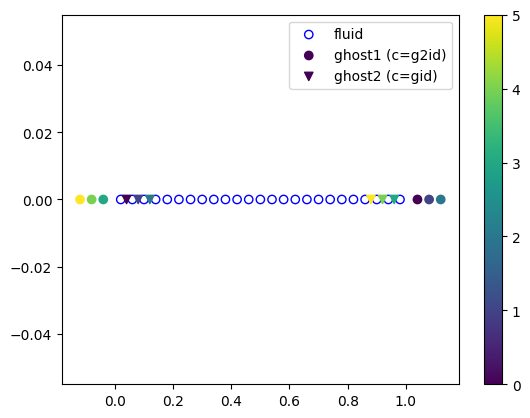

In [115]:
dim = 1
dx = 0.04
hdx = 1.2
num_layers = 3
pa = make_test_data(dx=dx, hdx=hdx, dim=dim)
g1pa, g2pa = create_ghosts([pa], dim=dim, dx=dx, num_layers=num_layers)
plot_periodic_pas(pa, g1pa, g2pa)

In [116]:
g1pa.get_property_arrays()

{'tag': array([0, 0, 0, 0, 0, 0], dtype=int32),
 'pid': array([0, 0, 0, 0, 0, 0], dtype=int32),
 'gid': array([0, 1, 2, 3, 4, 5], dtype=uint32),
 'x': array([ 1.04,  1.08,  1.12, -0.04, -0.08, -0.12]),
 'y': array([0., 0., 0., 0., 0., 0.]),
 'z': array([0., 0., 0., 0., 0., 0.]),
 'h': array([0.048, 0.048, 0.048, 0.048, 0.048, 0.048]),
 'p': array([0., 0., 0., 0., 0., 0.]),
 'av': array([0., 0., 0., 0., 0., 0.]),
 'au': array([0., 0., 0., 0., 0., 0.]),
 'v': array([0., 0., 0., 0., 0., 0.]),
 'm': array([0., 0., 0., 0., 0., 0.]),
 'rho': array([0., 0., 0., 0., 0., 0.]),
 'u': array([0., 0., 0., 0., 0., 0.]),
 'aw': array([0., 0., 0., 0., 0., 0.]),
 'w': array([0., 0., 0., 0., 0., 0.]),
 'g2id': array([0, 1, 2, 3, 4, 5], dtype=uint32),
 'exact': array([0., 0., 0., 0., 0., 0.]),
 'stride_test': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])}

In [113]:
pa.get_property_arrays()

{'tag': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int32),
 'pid': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int32),
 'gid': array([4294967295, 4294967295, 4294967295, 4294967295, 4294967295,
        4294967295, 4294967295, 4294967295, 4294967295, 4294967295,
        4294967295, 4294967295, 4294967295, 4294967295, 4294967295,
        4294967295, 4294967295, 4294967295, 4294967295, 4294967295,
        4294967295, 4294967295, 4294967295, 4294967295, 4294967295],
       dtype=uint32),
 'x': array([0.02, 0.06, 0.1 , 0.14, 0.18, 0.22, 0.26, 0.3 , 0.34, 0.38, 0.42,
        0.46, 0.5 , 0.54, 0.58, 0.62, 0.66, 0.7 , 0.74, 0.78, 0.82, 0.86,
        0.9 , 0.94, 0.98]),
 'y': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 'z': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,

In [114]:
g1pa.gid, g1pa.g2id

(array([0, 1, 2, 3, 4, 5], dtype=uint32),
 array([0, 1, 2, 3, 4, 5], dtype=uint32))

In [95]:
# pa.add_property('junk')
pa.properties.keys()

dict_keys(['tag', 'pid', 'gid', 'x', 'y', 'z', 'h', 'm', 'rho', 'exact', 'p', 'av', 'au', 'v', 'u', 'aw', 'w'])

In [96]:
g1pa.properties.keys()

dict_keys(['tag', 'pid', 'gid', 'x', 'y', 'z', 'h', 'g2id', 'p', 'av', 'au', 'v', 'm', 'rho', 'u', 'aw', 'w'])

In [99]:
g1pa.add_property(**{'name': 'new_junk', 'type': 'unsigned int', "data": [0, 1, 2, 3, 4, 5]})

In [100]:
g1pa.get_property_arrays()

{'tag': array([0, 0, 0, 0, 0, 0], dtype=int32),
 'pid': array([0, 0, 0, 0, 0, 0], dtype=int32),
 'gid': array([0, 1, 2, 3, 4, 5], dtype=uint32),
 'x': array([ 1.04,  1.08,  1.12, -0.04, -0.08, -0.12]),
 'y': array([0., 0., 0., 0., 0., 0.]),
 'z': array([0., 0., 0., 0., 0., 0.]),
 'h': array([0.048, 0.048, 0.048, 0.048, 0.048, 0.048]),
 'g2id': array([0., 1., 2., 3., 4., 5.]),
 'p': array([0., 0., 0., 0., 0., 0.]),
 'av': array([0., 0., 0., 0., 0., 0.]),
 'au': array([0., 0., 0., 0., 0., 0.]),
 'v': array([0., 0., 0., 0., 0., 0.]),
 'm': array([0., 0., 0., 0., 0., 0.]),
 'rho': array([0., 0., 0., 0., 0., 0.]),
 'u': array([0., 0., 0., 0., 0., 0.]),
 'aw': array([0., 0., 0., 0., 0., 0.]),
 'w': array([0., 0., 0., 0., 0., 0.]),
 'exact': array([0., 0., 0., 0., 0., 0.]),
 'new_junk': array([0, 1, 2, 3, 4, 5], dtype=uint32)}